### 1. Import the VGG-19 model

In [1]:
import tensorflow as tf
from tensorflow.python.keras.applications.vgg19 import VGG19

C:\Users\nsingh2\Anaconda3\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
model = VGG19(include_top=False,
             weights = 'imagenet') 

model.trainable = False
model.summary()

80142336/80134624 [==============================] - 107s 1us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
____________________________________________________________

### 2. Import Libraries

In [3]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### 3. Image Processing and Display

In [4]:
content_image_path = "content.jpg"
style_image_path = "style.jpg"
size = 224

In [5]:
def preprocess_image(image_path):
    img = load_img(image_path) 
    img = img_to_array(img) 
    img = preprocess_input(img)
    return np.expand_dims(img,axis=0) 

In [6]:
def deprocess(x):
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

def display_image(image):
    if len(image.shape) == 4:
        image = image[0,:,:,:]

    img = deprocess(image)
    
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.show()

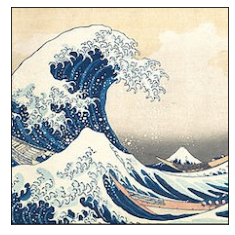

In [7]:
display_image(preprocess_image(style_image_path))

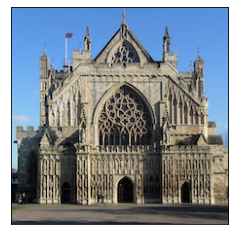

In [8]:
display_image(preprocess_image(content_image_path))

### 4.  Content and Style Models

In [9]:
content_layer = 'block5_conv2'

content_model = tf.keras.models.Model(
    inputs=model.input,
    outputs=model.get_layer(content_layer).output
)

style_layers = [
    'block1_conv1',
    'block3_conv1', 
    'block5_conv1'
    ]

style_models = [
    tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(layer).output)
    for layer in style_layers
]

### 5. Content Cost

In [10]:
def content_cost(content, generated):
    a_C = content_model(content)
    a_G = content_model(generated)
    cost = tf.reduce_mean(tf.square(a_C - a_G))
    return cost

### 6. Gram Matrix

In [11]:
def gram_matrix(A):
    n_C = int(A.shape[-1])
    a = tf.reshape(A, [-1,n_C])
    n = tf.shape(a)[0]
    G = tf.matmul(a, a, transpose_a=True)
    return G / tf.cast(n, tf.float32)

### 7. Style cost

In [12]:
lam = 1. / len(style_models)

def style_cost(style, generated):
    J_style = 0
    
    for style_model in style_models:
        a_S = style_model(style)
        a_G = style_model(generated)
        GS = gram_matrix(a_S)
        GG = gram_matrix(a_G)
        current_cost = tf.reduce_mean(tf.square(GS-GG))
        J_style += current_cost*lam
    
    return J_style

### 8. Training Loop

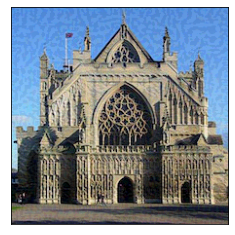

Iteration:1/1000, Total Cost:68669933617152.0, Style Cost: 686699328.0, Content Cost: 0.0


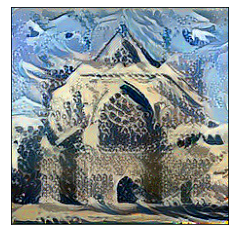

Iteration:101/1000, Total Cost:651215306752.0, Style Cost: 6512153.0, Content Cost: 7703.07861328125


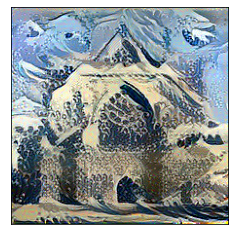

Iteration:201/1000, Total Cost:407224090624.0, Style Cost: 4072241.0, Content Cost: 7899.0625


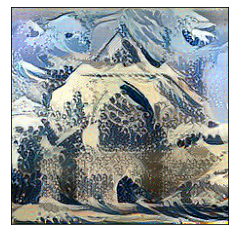

Iteration:301/1000, Total Cost:312435769344.0, Style Cost: 3124357.75, Content Cost: 8025.26513671875


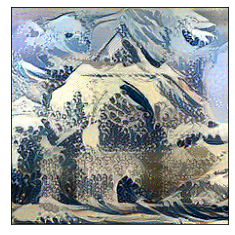

Iteration:401/1000, Total Cost:256776552448.0, Style Cost: 2567765.5, Content Cost: 8095.158203125


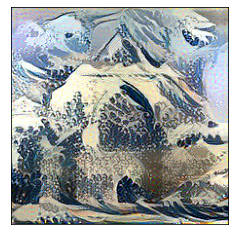

Iteration:501/1000, Total Cost:220287107072.0, Style Cost: 2202871.0, Content Cost: 8149.71826171875


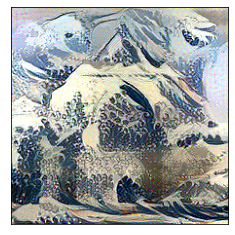

Iteration:601/1000, Total Cost:191389548544.0, Style Cost: 1913895.5, Content Cost: 8187.72705078125


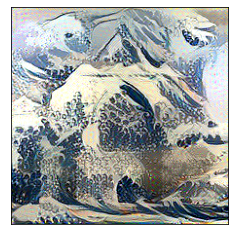

Iteration:701/1000, Total Cost:178754371584.0, Style Cost: 1787543.5, Content Cost: 8225.658203125


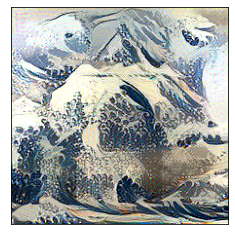

Iteration:801/1000, Total Cost:159942787072.0, Style Cost: 1599427.75, Content Cost: 8240.400390625


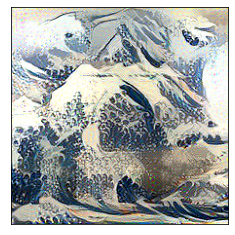

Iteration:901/1000, Total Cost:144939843584.0, Style Cost: 1449398.25, Content Cost: 8287.421875


In [20]:
content_image_preprocessed = preprocess_image(content_image_path)
style_image_preprocessed = preprocess_image(style_image_path)
generated_image = tf.Variable(content_image_preprocessed, dtype=tf.float32)

generated_images = []
costs = []
lr = 7.0 
iterations = 1000
style_wt = 1e5
content_wt = 1.0

optimizer = tf.optimizers.Adam(learning_rate=lr)

for i in range(iterations):
    
    with tf.GradientTape() as tape:
        J_content = content_cost(content_image_preprocessed, generated_image)
        J_style = style_cost(style_image_preprocessed, generated_image)
        J_total = content_wt * J_content + style_wt * J_style
    
    gradients = tape.gradient(J_total, generated_image)
    optimizer.apply_gradients([(gradients, generated_image)])
    
    costs.append(J_total.numpy())
    
    if i % 100 == 0:
        display_image(generated_image.numpy())
        generated_images.append(generated_image.numpy())
        print("Iteration:{}/{}, Total Cost:{}, Style Cost: {}, Content Cost: {}".format(i+1, iterations, J_total, J_style, J_content))

### 9. Plot the Results

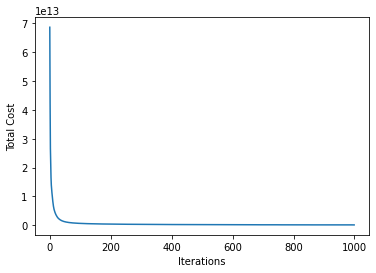

In [21]:
plt.plot(range(iterations), costs)
plt.xlabel("Iterations")
plt.ylabel("Total Cost")
plt.show()

In [23]:
from PIL import Image
image = Image.fromarray(deprocess(generated_images[-1][0]))

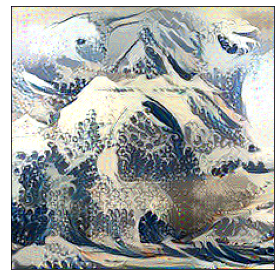

In [24]:
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig('out.png')